In [13]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
#sys.path.append("../..") # add standard 's modules
# sys.path.append('/home/hbkoziel/pyfesom/codes/modules')
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time
import pandas as pd
import xarray as xr

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap
# Define local pass #
wd_path = '/home/hbkoziel/pyfesom'

In [14]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
runid	= 'Arc12'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=False)        # Loading mesh, stores it in mesh.****  

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [19]:
# PLOT CONFIGURATION #

# figure export 
export_plot = True
# figure export definition
dpicnt=150
# choose simulation
runid='Arc12'
# choose date
first_year = 1980
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
months =np.linspace(0,11,12).astype(int)
# choose depth
get3d = False
# load the given biological tracer #
var_id= 'area'

########################

# AUTOMATIC DEFINITION OF PATHS
resultpath = '/scratch/usr/hbkvsk12/hlrn3_work2/results/'+runid+'/'
savepath    = wd_path+'/figures/'+runid+'/validation/'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'

In [20]:
ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
f           = Dataset(ncfile, 'r')
NodalAreaModel = f.variables['cluster_area'][:]

In [21]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

JAN
FEV
MAR
APR
MAY
JUN
JUL
AUG
SEP
OCT
NOV
DEC


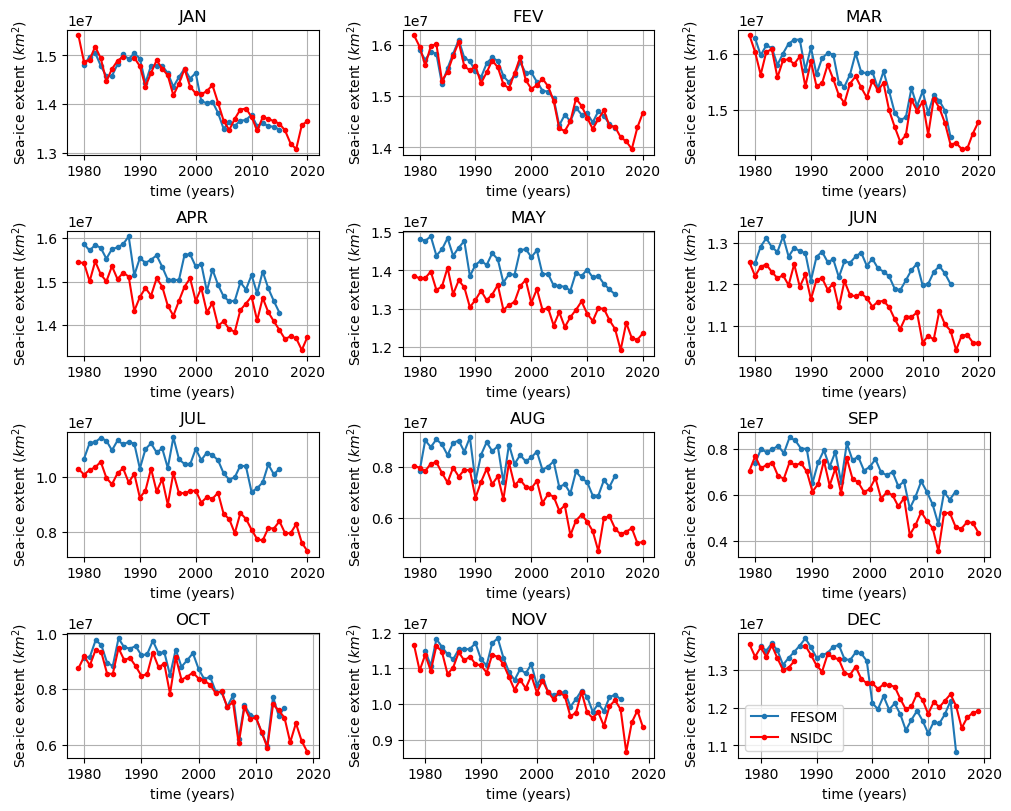

In [25]:
#X = genfromtxt(outputpath+'ICE_APR_1990_2015_trend.csv', delimiter=';')
#fig, axs = plt.subplots(3,2, sharex=True, sharey=True)
figsize = (10, 8)
rows,cols = 4,3
months = range(0,12)

axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows,cols)
plt.style.use('seaborn-whitegrid')
plt.style.use('default')
axs = trim_axs(axs, len(months))

for ax, mo in zip(axs, months):
    if mo ==0: 
        dayind = (range(0,15))
        month='JAN'
    if mo ==1: 
        dayind = (range(15,30))
        month='FEV'
    if mo ==2: 
        dayind = (range(30,45))
        month='MAR'
    if mo ==3: 
        dayind = (range(45,60))
        month='APR'
    elif mo ==4: 
        dayind = (range(60,75))
        month='MAY'
    elif mo ==5: 
        dayind = (range(75,90))
        month='JUN'
    elif mo ==6: 
        dayind = (range(90,105))
        month='JUL'
    elif mo ==7:
        dayind = (range(105,120))
        month='AUG'
    elif mo ==8: 
        dayind = (range(120,135))
        month='SEP'
    elif mo ==9: 
        dayind = (range(135,150))
        month='OCT'
    elif mo ==10: 
        dayind = (range(150,165))
        month='NOV'
    elif mo ==11: 
        dayind = (range(165,174))
        month='DEC'
    
    print month
    
    # initlialyze
    ICECON = np.zeros((len(years),len(mesh.x2)))
    ICEAREA = np.zeros((len(years),len(mesh.x2)))

    # loop over years
    for ind in range(0,len(years)):
         #print years[ind]
         if years[ind] == 2015 and mo == 11: # exception for the end of the time-series
            dayind = range(165,167)
            
         ncfile = resultpath+runid+'.'+str(years[ind])+'.ice.mean.nc'
         #print ncfile
         f      = Dataset(ncfile, 'r')
         if years[ind]<2000:
             ice    = f.variables[var_id][mo,0:mesh.n2d]
         else:
             ice    = f.variables[var_id][dayind,0:mesh.n2d].mean(axis=0)
             #ice    = ice / (len(dayind))
         arcsurf_ind = np.nonzero((mesh.y2>45.) & (ice>0.1))
         ICEAREA[ind,:]=np.sum(NodalAreaModel[arcsurf_ind])
         ICECON[ind,:] =np.mean(ice[mesh.y2>66.])
    
    if mo < 9:
        BSOfile = wd_path+'/data/NSIDC/N_0'+str(mo+1)+'_extent_v3.0.csv'
        #print BSOfile
        df = pd.read_csv(BSOfile, header=0, sep = ',',na_values=['-9999'], decimal=".",skipinitialspace=True)
    else:
        BSOfile = wd_path+'/data/NSIDC/N_'+str(mo+1)+'_extent_v3.0.csv'
        #print BSOfile
        df = pd.read_csv(BSOfile, header=0, sep = ',',na_values=['-9999'], decimal=".",skipinitialspace=True)
    icearea=ICEAREA.mean(axis=1)/1e6
    ax.plot(years,icearea,'.-')
    ax.plot(df.year,df.extent*1e6,'.-r')
    ax.grid(True)
    ax.set_xlabel('time (years)')
    ax.set_ylabel('Sea-ice extent ($km^2$)')
    ax.set_title(month)
    legend(['FESOM','NSIDC'])
    
plt.savefig(savepath+'SEAICEEXTENT_timeseries_'+str(first_year)+'_'+str(last_year)+'.png', dpi = dpicnt, bbox_inches='tight')      